In [ ]:
# Install python v3.11 to work with pyBATMAN
!sudo apt-get update -y -qq
!sudo apt-get install -qq python3.11 python3.11-dev python3.11-distutils libpython3.11-dev
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
!sudo update-alternatives --config python3

# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall -qq

# Add packages to system path
import sys
sys.path.append("/usr/local/lib/python3.11/dist-packages")

There is only one alternative in link group python3 (providing /usr/bin/python3): /usr/bin/python3.11
Nothing to configure.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2570k  100 2570k    0     0  14.6M      0 --:--:-- --:--:-- --:--:-- 14.5M


In [ ]:
# Install pyBATMAN
!pip install pybatman -qq

In [ ]:
# Load two main functions from pyBATMAN
from pybatman.functions import train, peptide2index

In [ ]:
# Import packages for downstream analysis of BATMAN outputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# (Note that for some reason, pyBATMAN is not able to load AA matrix data, so we supply it ourselves)
AA_matrix_prior = pd.read_csv('blosum100.csv',index_col=0)

In [ ]:
#Train pyBATMAN and infer full asymmetric AA matrix and TCR-specific weights (takes ~5m to run)
inferred_weights, inferred_AA_matrix = train('test_input.csv','full',AA_matrix_prior)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


In [90]:
#Generate peptide2index distances for a selected TCR with trained pyBATMAN
#Read data
peptide_data = pd.read_csv('test_input.csv')

# Extract data for a particular TCR
tcr_name = 'TCR1'

index_peptide = peptide_data[peptide_data.tcr==tcr_name]['index'].tolist()

mutant_peptide_list = peptide_data[peptide_data.tcr==
                                   tcr_name]['peptide'].tolist()

# Inferred positional weight profile for the selected TCR
weight_profile = inferred_weights.loc[[tcr_name]].to_numpy()

# generate peptide-to-index distances with pyBATMAN
peptide_distance = peptide2index(index_peptide,
                                 mutant_peptide_list,
                                 inferred_AA_matrix,
                                 weight_profile)

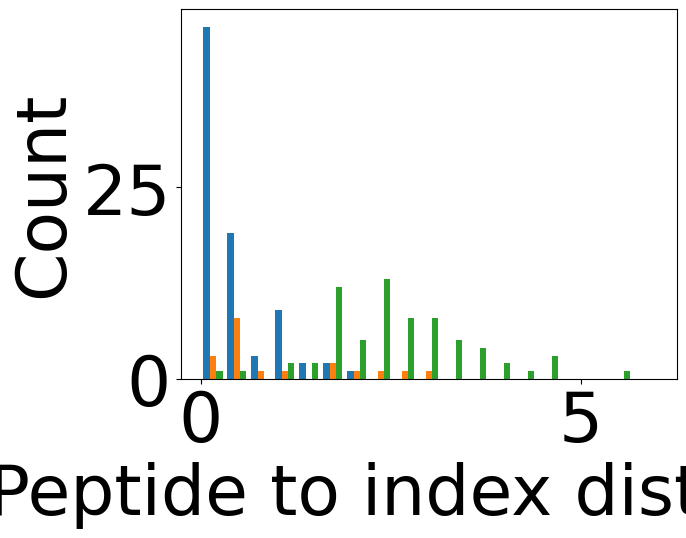

In [91]:
#plot histogram of peptides-to-index distances for 3 classes

activation_level = peptide_data[peptide_data.tcr
                                ==tcr_name]['activation'].to_numpy()
bins = np.linspace(0, 6, 20)
plt.hist([peptide_distance[activation_level == 2],
          peptide_distance[activation_level == 1],
          peptide_distance[activation_level == 0]],
         bins, label=['strong activation', 'weak activation', 'no activation'])
plt.xlabel('Peptide to index distance')
plt.ylabel('Count')
plt.show()

In [ ]:
#visualize inferred matrices (symm and antisymm part), plot auc, clustering of peptides,
# different training modes, within TCR and cross-TCR